In [155]:
#SET UP ENVIRONMENT

import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import restoration, filters, segmentation, metrics, morphology, color
from skimage.util import random_noise
from google.colab import files
%matplotlib inline


Saving 4.jpg to 4 (3).jpg


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

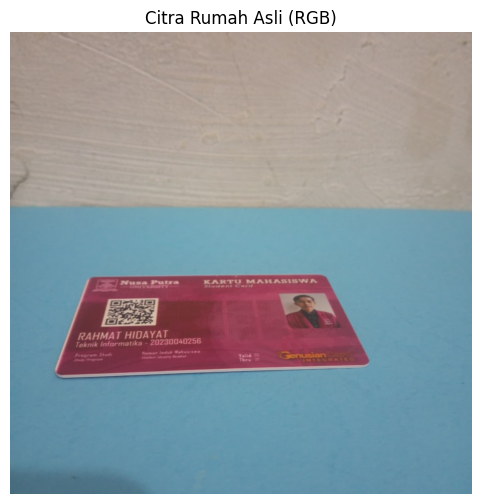

In [156]:
#AKUISISI IMAGE

uploaded = files.upload()

# Ambil satu file gambar
image_path = list(uploaded.keys())[0]

# Load image (OpenCV default BGR → convert ke RGB)
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title("Citra Rumah Asli (RGB)")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

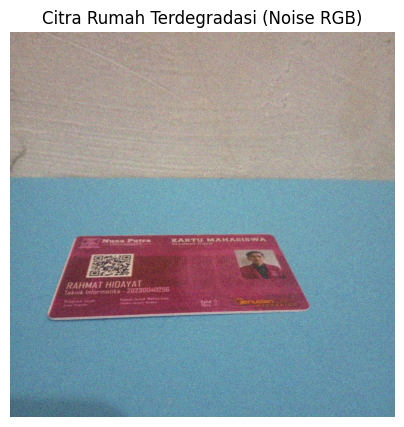

In [157]:
#PENAMBAHAN GAUSSIAN NOISE

noisy_img = random_noise(img_rgb, mode='gaussian', var=0.01)
noisy_img = (noisy_img * 255).astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(noisy_img)
plt.title("Citra Rumah Terdegradasi (Noise RGB)")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

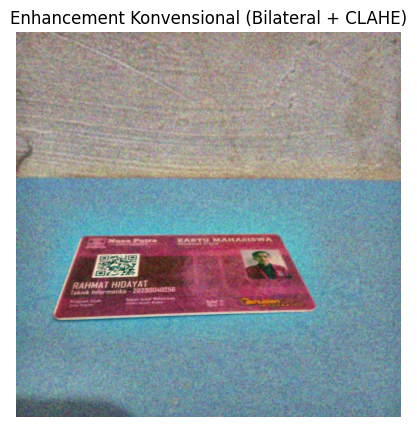

In [158]:
# DENOISING TRADITIONAL + CLAHE
denoise_trad = cv2.bilateralFilter(noisy_img, 9, 75, 75)

# CLAHE RGB
def clahe_rgb(img):
    clahe = cv2.createCLAHE(2.0, (8,8))
    channels = cv2.split(img)
    out = [clahe.apply(c) for c in channels]
    return cv2.merge(out)

enh_trad = clahe_rgb(denoise_trad)

plt.figure(figsize=(5,5))
plt.imshow(enh_trad)
plt.title("Enhancement Konvensional (Bilateral + CLAHE)")
plt.axis("off")


In [159]:
#PERSIAPAN DATA LATIH
# Parameter patch
PATCH_SIZE = 7
STRIDE = 3

def extract_patches(img, patch_size, stride):
    patches = []
    h, w, c = img.shape
    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            patch = img[y:y+patch_size, x:x+patch_size, :]
            patches.append(patch.flatten())
    return np.array(patches)


# Input training: noisy image
X_train = extract_patches(noisy_img, PATCH_SIZE, STRIDE)

# Target training: enhanced reference (CLAHE output sebagai proxy GT)
Y_train = extract_patches(enh_trad, PATCH_SIZE, STRIDE)

print("Training samples:", X_train.shape)


Training samples: (180625, 147)


In [160]:
#PELATIHAN MODEL
# Tambahkan bias
X_aug = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Least Squares Training
W = np.linalg.lstsq(X_aug, Y_train, rcond=None)[0]

print("Model trained: Weight matrix shape =", W.shape)


Model trained: Weight matrix shape = (148, 147)


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

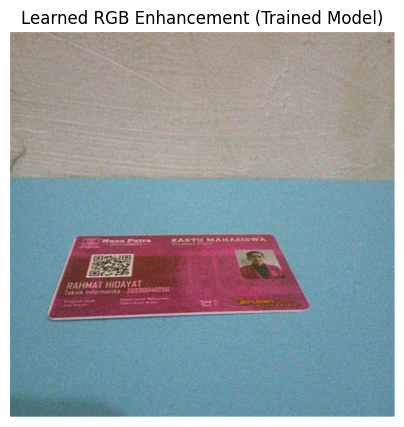

In [161]:
#INFERENSI ENCHANCEMENT
def apply_learned_enhancement(img, W, patch_size):
    h, w, c = img.shape
    out = img.copy().astype(np.float32)
    count = np.zeros_like(out)

    for y in range(0, h - patch_size, 1):
        for x in range(0, w - patch_size, 1):
            patch = img[y:y+patch_size, x:x+patch_size, :].flatten()
            patch_aug = np.append(patch, 1)
            pred = patch_aug @ W
            pred = pred.reshape((patch_size, patch_size, 3))

            out[y:y+patch_size, x:x+patch_size, :] += pred
            count[y:y+patch_size, x:x+patch_size, :] += 1

    return np.clip(out / (count + 1e-8), 0, 255).astype(np.uint8)


enh_dl = apply_learned_enhancement(noisy_img, W, PATCH_SIZE)

plt.figure(figsize=(5,5))
plt.imshow(enh_dl)
plt.title("Learned RGB Enhancement (Trained Model)")
plt.axis("off")


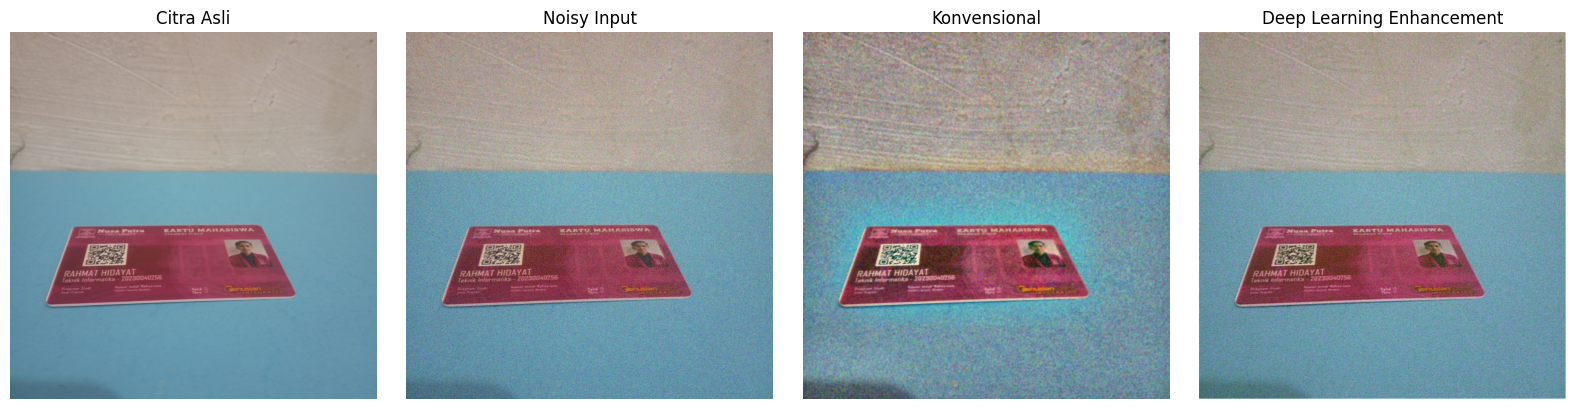

In [162]:
# PERBANDINGAN TRADITIONAL VS DEEP LEARNING

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(img_rgb)
plt.title("Citra Asli")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(noisy_img)
plt.title("Noisy Input")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(enh_trad)
plt.title("Konvensional")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(enh_dl)
plt.title("Deep Learning Enhancement")
plt.axis("off")

plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

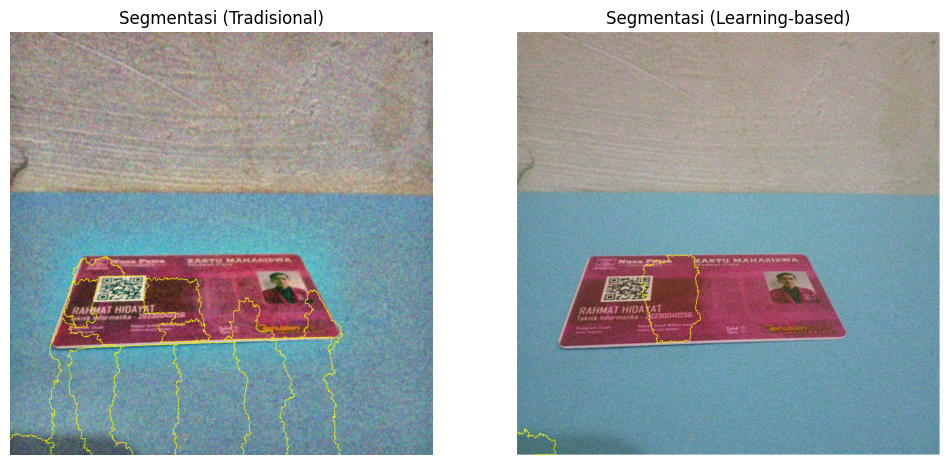

In [163]:
#SEGEMENTASI OBJEK
# Gunakan slic superpixel
segments_trad = segmentation.slic(
    enh_trad, n_segments=300, compactness=10, start_label=1
)

segments_dl = segmentation.slic(
    enh_dl, n_segments=300, compactness=10, start_label=1
)

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].imshow(segmentation.mark_boundaries(enh_trad, segments_trad))
ax[0].set_title("Segmentasi (Tradisional)")
ax[0].axis("off")

ax[1].imshow(segmentation.mark_boundaries(enh_dl, segments_dl))
ax[1].set_title("Segmentasi (Learning-based)")
ax[1].axis("off")


In [164]:
# Segmentasi sederhana sebagai ground truth pendekatan
gt = cv2.inRange(img_rgb, (100, 100, 100), (255, 255, 255))
gt = morphology.remove_small_objects(gt.astype(bool), min_size=500)
gt = gt.astype(np.uint8)


In [165]:
#EVALUASI KUALITAS GAMBAR

def evaluate_segmentation(pred, gt):
    """
    pred, gt : binary mask (True/False atau 0/1)
    """
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()

    dice = (2 * intersection) / (pred.sum() + gt.sum() + 1e-8)
    iou = intersection / (union + 1e-8)

    return dice, iou


# Ambil satu region dominan sebagai objek (pendekatan studi kasus)
seg_trad_binary = segments_trad == np.bincount(segments_trad.flatten()).argmax()
seg_dl_binary   = segments_dl   == np.bincount(segments_dl.flatten()).argmax()

dice_trad, iou_trad = evaluate_segmentation(seg_trad_binary, gt)
dice_dl, iou_dl     = evaluate_segmentation(seg_dl_binary, gt)

print("=== Evaluasi Segmentasi ===")
print(f"Tradisional → Dice: {dice_trad:.3f}, IoU: {iou_trad:.3f}")
print(f"Learning-based → Dice: {dice_dl:.3f}, IoU: {iou_dl:.3f}")


=== Evaluasi Segmentasi ===
Tradisional → Dice: 0.868, IoU: 0.766
Learning-based → Dice: 0.860, IoU: 0.754
